# OpenCV: разрезка и OCR изображения по разметке в CVAT

In [2]:
import cv2
from matplotlib import pyplot as plt
import json
import pytesseract
import pandas as pd

In [3]:
IMG_PATH = 'img/'
img_name = 'passportv'

## Вывод изображения и вырезка произвольной области

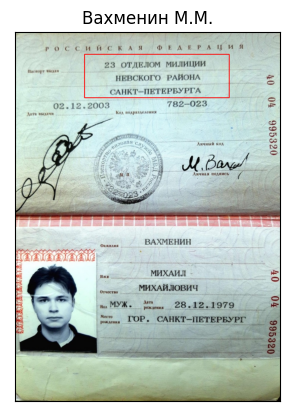

In [4]:
img = cv2.imread(IMG_PATH + img_name + '.jpg') # чтение изображения
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # конвертация из BGR в RGB
x1, y1 = 240, 80 # верхний левый угол рамки
x2, y2 = x1 + 500, y1 + 150 # нижний правый угол рамки
cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2) 
plt.imshow(img)
plt.xticks([]) # удаляем горизонтальную шкалу
plt.yticks([]) # удаляем вертикальную шкалу
plt.title('Вахменин М.М.')
None

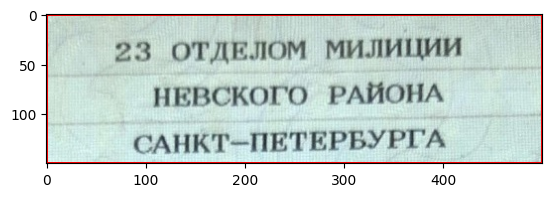

In [5]:
crop_img = img[y1:y2, x1:x2] # считанное изображение OpenCV - это просто numpy array, фильтруем
plt.imshow(crop_img)
None

## Загрузка файла разметки, разрезка файла по разметке и OCR

Имя файла: passportv.jpg
Разрешение: 1278 x 916


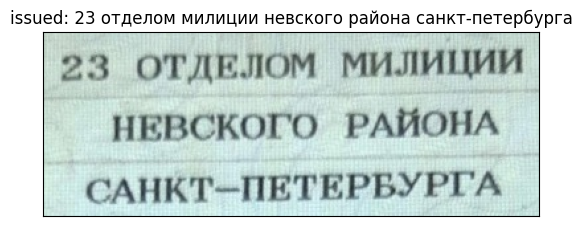

23 ОТДЕЛОМ МИЛИЦИИ
НЕВСКОГО РАЙОНА
САНКТ-ПЕТЕРБУРГА



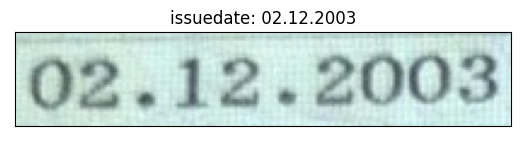

02.12.2003



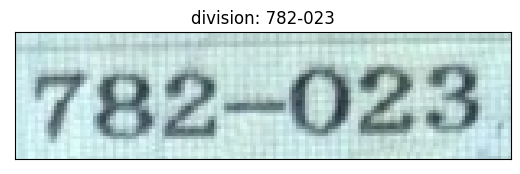

782—023



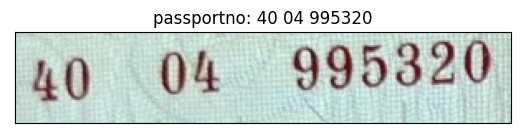

4004995320



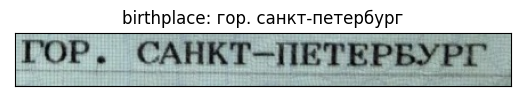

ГОР. САНКТ-ПЕТЕРБУРГ



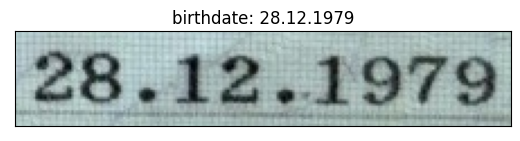

28.12.1979



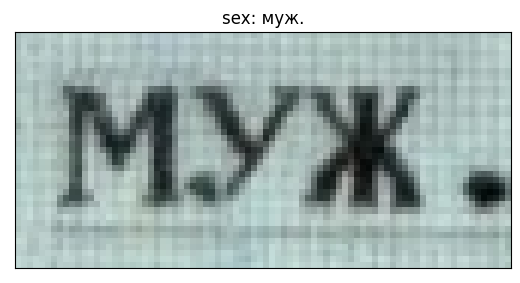

МУЖ.



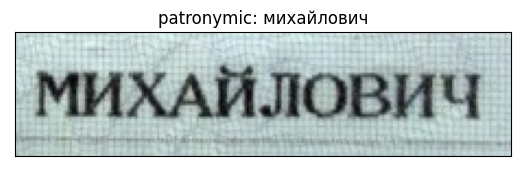

МИХАЙЛОВИЧ



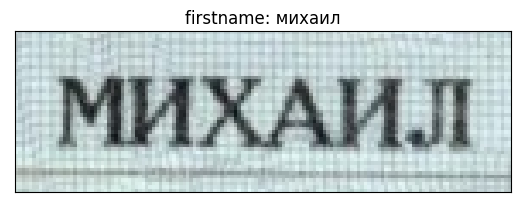

МИХАИЛ



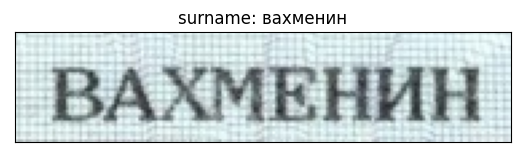

ВАХМЕНИН



,Метка,Значение
1,firstname,МИХАИЛ
2,surname,ВАХМЕНИН
3,patronymic,МИХАЙЛОВИЧ
4,sex,МУЖ.
5,birthdate,28.12.1979
6,birthplace,ГОР. САНКТ-ПЕТЕРБУРГ
7,issued,23 ОТДЕЛОМ МИЛИЦИИ НЕВСКОГО РАЙОНА САНКТ-ПЕТЕР...
8,issuedate,02.12.2003
9,division,782—023
10,passportno,4004995320


In [18]:
with open(f'{IMG_PATH}{img_name}.json') as f:
    annotation = json.load(f)

print('Имя файла:', annotation['images'][0]['file_name'])
print('Разрешение:', annotation['images'][0]['height'], 'x', annotation['images'][0]['width'])
img = cv2.imread(IMG_PATH + annotation['images'][0]['file_name']) # чтение изображения
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # конвертация из BGR в RGB

categories = {}
for category in annotation['categories']: # создаем словарь с перечнем категорий из файла разметки
    categories[category['id']] = category['name']
df_result = pd.DataFrame(columns=['Метка', 'Значение'])

for anno in annotation['annotations']:
    top_left_x, top_left_y = int(anno['bbox'][0]), int(anno['bbox'][1]) # координаты левого верхнего угла области для распознавания
    bottom_right_x, bottom_right_y = int(top_left_x + anno['bbox'][2]), int(top_left_y + anno['bbox'][3]) # координаты правого нижнего угла области для распознавания
    crop_img = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x] # обрезка области для распознавания
    if categories[anno['category_id']] == 'passportno': # поворот номера паспорта на 90 градусов
        crop_img = cv2.rotate(crop_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(crop_img)
    plt.xticks([]) # удаляем горизонтальную шкалу
    plt.yticks([]) # удаляем вертикальную шкалу
    plt.title(categories[anno['category_id']] + ': ' + anno['attributes']['text']) # заголовок с текстом из разметки
    plt.show()
    if categories[anno['category_id']] == 'passportno': # специальные настройки для распознавания номера паспорта
        ocr_text = pytesseract.image_to_string(crop_img, lang='eng', \
        config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
    else:
        ocr_text = pytesseract.image_to_string(crop_img, lang='rus')
    print(ocr_text)
    df_result.loc[anno['category_id']] = [categories[anno['category_id']], ocr_text.replace('\n', ' ').strip()]
df_result.sort_index()